# Diagrama de interacción P-M (Seccion Concreto)

## Librerías principales

In [1]:
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt
import opsvis as opsv
from math import pi, sqrt

import handcalcs.render
import forallpeople as si

## Unidades basicas y derivadas

In [2]:
%%render

kgf = 1.0
cm = 1.0

m=100*cm
N=9.81*kgf

MPa=10**6*N/m**2

<IPython.core.display.Latex object>

## Materiales

### Concreto

In [3]:
%%render params long

#Concreto
fpc=210*kgf/cm**2   #Resistencia del concreto, kgf/cm**2
ɛcu =0.003          #Deformación unitaria máxima
Ec=15100*sqrt(fpc)   #Módulo elástico del concreto,   kgf/cm**2

<IPython.core.display.Latex object>

### Acero

In [4]:
%%render  params long

#Acero
fy = 4200*kgf/cm**2     #Esfuerzo de fluencia del acero, kgf/cm**2
Es = 2*10**6*kgf/cm**2  #Módulo elástico del acero, kgf/cm**2
ɛy = 0.0021             #Deformacción unitaria de fluencia
ɛsu = 60*ɛy             #Deformación unitaria última

<IPython.core.display.Latex object>

## Geometría

In [5]:
%%render  long params

#Forma de la sección: Rectangular
b = 30*cm     #Base del rectángulo
h = 60*cm     #Altura del rectángulo
Ag=b*h        #Área bruta de la sección

<IPython.core.display.Latex object>

In [6]:
%%render

#Refuerzos de acero
Nbars=[2,2,3]            #Número de barras de aceros en cada capa desde la fibra más comprimida
ds=[6*cm,30*cm,54*cm]      #Posición desde la fibra más comprimida.
db=[2.54*cm,2.54*cm,2.54*cm] #Diámetros: Asc, Asi, Ast

As=[Nbars[i]*pi*db[i]**2/4 for i in range(len(ds))]  #Área de acero en cada capa
Asb=sum(As)                                             #Área total, acero longitudinal

<IPython.core.display.Latex object>

### Sección transversal

TypeError: Polygon.__init__() takes 2 positional arguments but 3 were given

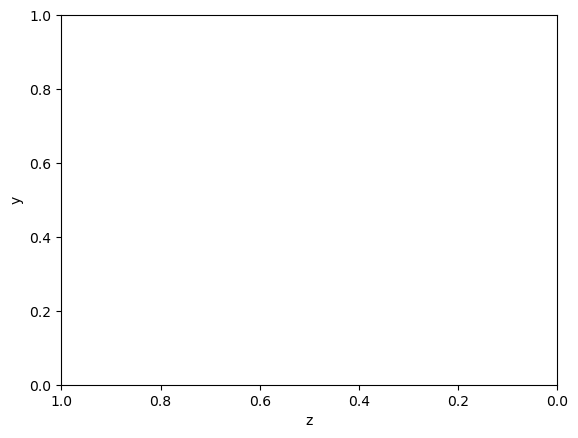

In [7]:
fib_sec_1 = [['section','Fiber',1],
             ['patch','rect',2,1,1,h/2,b/2,-h/2,-b/2],
             ['layer','straight',1,Nbars[0],As[0],h/2-ds[0],b/2-ds[0],h/2-ds[0],-b/2+ds[0]],
             ['layer','straight',1,Nbars[1],As[1],0,b/2-ds[0],0,-b/2+ds[0]],
             ['layer','straight',1,Nbars[2],As[2],-h/2+ds[0],b/2-ds[0],-h/2+ds[0],-b/2+ds[0]]]
matcolor = ['r','lightgrey','gold','w','w','w']
opsv.plot_fiber_section(fib_sec_1,matcolor=matcolor)
plt.axis('equal')
plt.show()

## Curva de los materiales

###  Acero

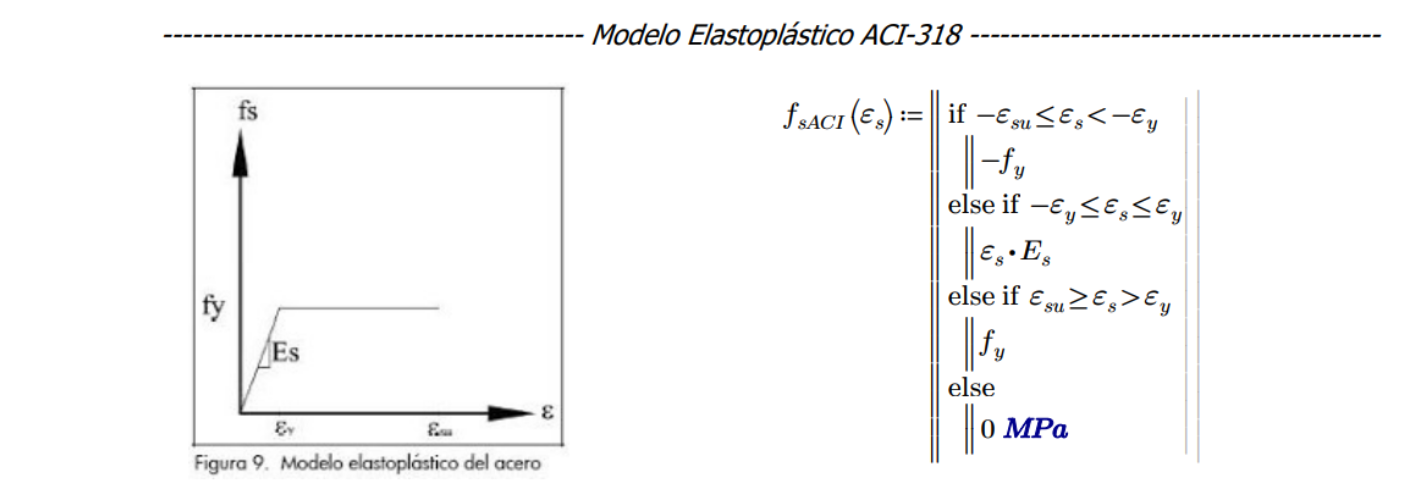

In [ ]:
def fs(fy,εs):
    if -ɛsu<=εs<-ɛy:
        fss=-fy
    elif -ɛy<=εs<=ɛy:
        fss=εs*Es
    elif ɛsu>=εs>ɛy:
        fss=fy
    else:
        fss=0
    return fss

###  Concreto

####  Coeficiente beta

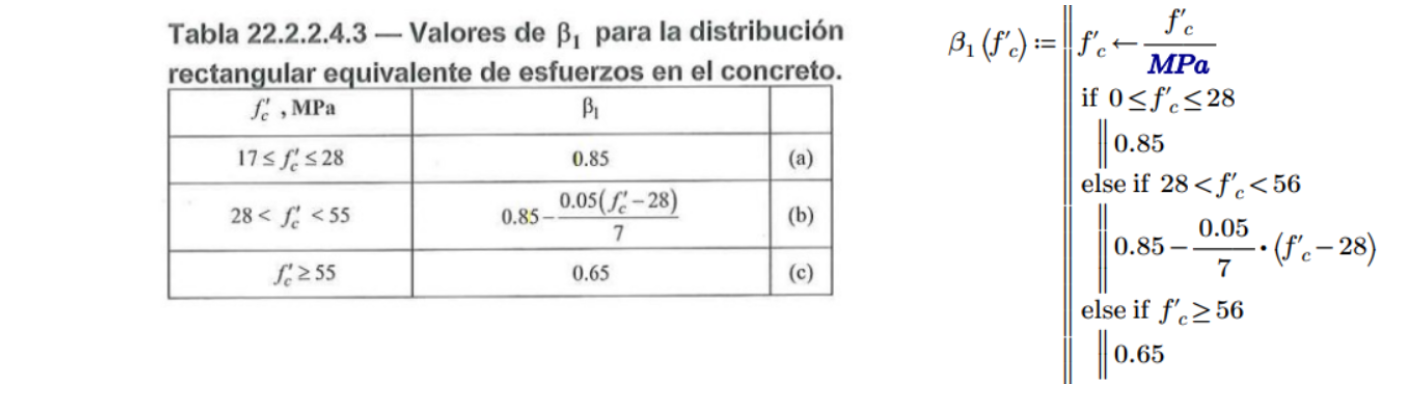

In [ ]:
#coeficiente beta
def ß(fpc):
    if 0<=fpc<=280:
        beta=0.85
    elif 280<fpc<560:
        beta=0.85-(0.05/70)*(fpc-280)
    elif fpc>=56:
        beta=0.65
    return beta

####  Coeficiente phi  -  ACI 318-19

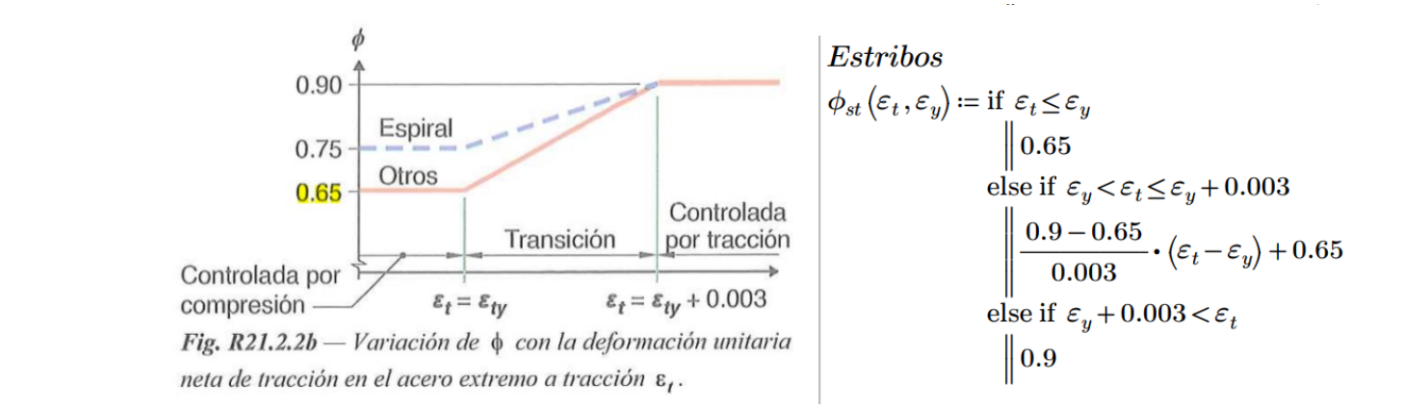

In [ ]:
#Coeficiente ACI 318-19 phi
def ɸ(ɛy,ɛt):
    if ɛt<=ɛy:
        phi=0.65
    elif ɛy<ɛt<ɛy+0.003:
        phi=(0.9-0.65)/0.003*(ɛt-ɛy)+0.65
    elif ɛy+0.003<ɛt:
        phi=0.9
    return phi

#### Coeficiente phi  -  E.060

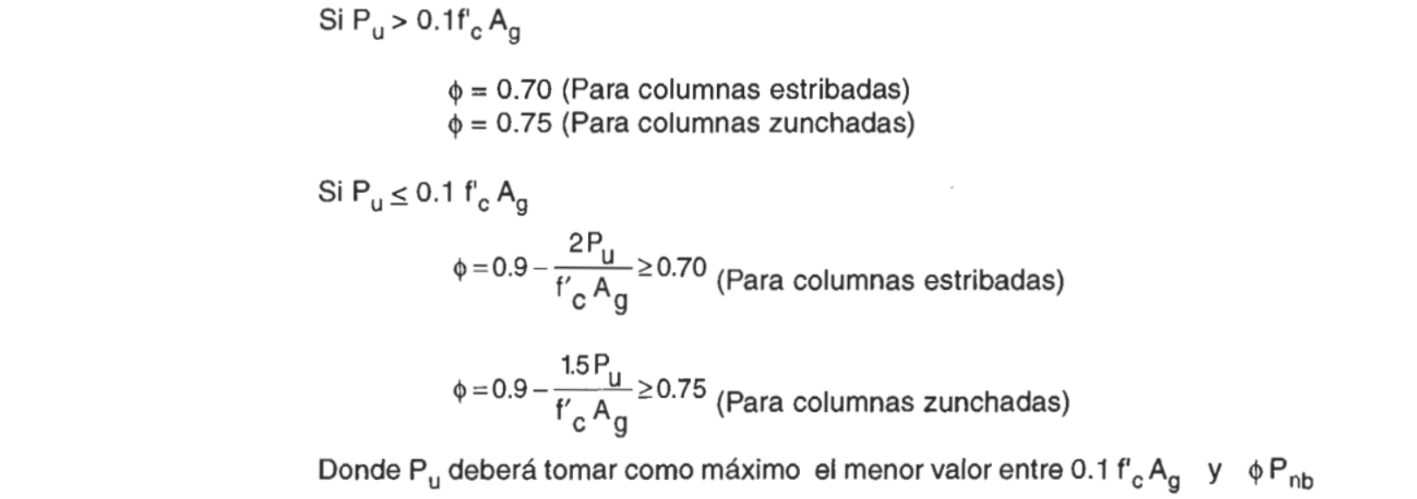

In [ ]:
#Coeficiente NTP E 060 phi
def ɸp(Pu):
    if -Pu>-0.1*fpc*Ag:
        phi=0.9
    elif -Pu<=-0.1*fpc*Ag:
        phi=max(0.9-2*Pu/(fpc*Ag),0.7)
    return phi

#### Curva de esfuerzo - Bloque de Whitney

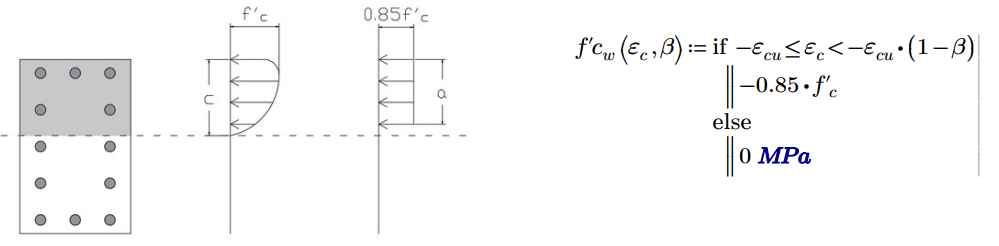

In [ ]:
#Compresión
def fc(fpc,ɛ):
    if -ɛcu<=ɛ<=-ɛcu*(1-ß(fpc)):
        fcs=-0.85*fpc
    else:
        fcs=0
    return fcs

## Generación de puntos de la curva

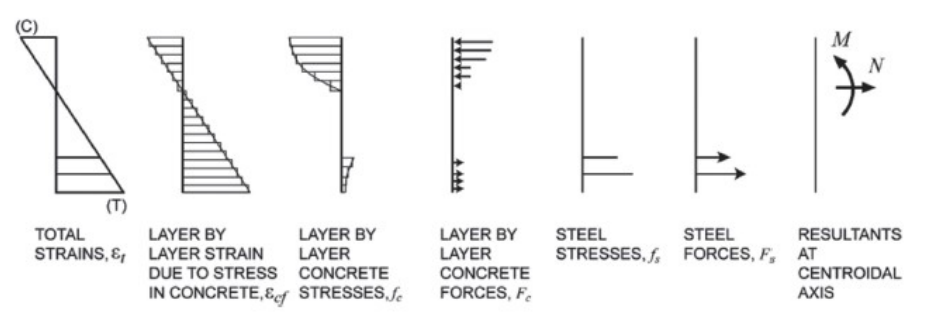

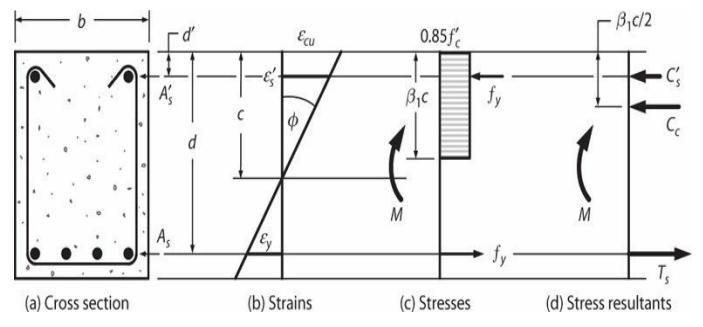

### Parámetros iniciales

In [ ]:
%%render 

n=500       #Número de fibras en la sección
d=ds[-1]    #Peralte efectivo de la sección
t0=h/n      #Espesor de cada fibra.

In [ ]:
tp=[h/n for i in range(n)]
bp=[b for i in range(n)]
y=[tp[-1]/2 + tp[n-2-i]*(n-1-i) for i in range(n)]
ys=[h-ds[i] for i in range(len(ds))]

###  Generación de la curva

In [ ]:
%%render params long

Pn=0

## Primeros puntos: en tracción
Mnp=[0]               #Momento nominal en tracción
Pnp=[Asb*fy]          #Fuerza Axial Nominal en tracción, máxima
ɸMnp=[-0.9*0]         #Momento último de diseño ACI 318-19
ɸPnp=[0.9*Asb*fy]     #Fuerza axial última de diseño ACI 318-19
ɸMnp2=[-0.9*0]        #Momento ultimo de diseño E.060
ɸPnp2=[0.9*Asb*fy]    #Fuerza axial última nominal E.060

c2=1

In [ ]:
while Pn<=0.8*Ag*fpc:
    error=10
    c1=1
    c3=h    
    while error>0.01:
        ε0=(h/c1-1)*ɛcu
        εc=[(h-y[i])/h*(ɛcu+ε0)-ɛcu for i in range(n)]
        εs=[-(c1-ds[i])/c1*ɛcu for i in range(len(ds))]
        #Fuerza axial cuando c=c1
        FN1=Pn+sum([fc(fpc,εc[i])*bp[i]*tp[i] for i in range(n)])+sum([(fs(fy,
                                                                        εs[i])-fc(fpc,εs[i]))*As[i] for i in range(len(ds))])
        
        c2=(c1+c3)/2
        ε0=(h/c2-1)*ɛcu
        εc=[(h-y[i])/h*(ɛcu+ε0)-ɛcu for i in range(n)]
        εs=[-(c2-ds[i])/c2*ɛcu for i in range(len(ds))]
        #Fuerza axial cuando c=c2
        FN2=Pn+sum([fc(fpc,εc[i])*bp[i]*tp[i] for i in range(n)])+sum([(fs(fy,
                                                                        εs[i])-fc(fpc,εs[i]))*As[i] for i in range(len(ds))])
        
        error=abs(FN1-FN2)

        #Método de la bisección
        if FN1*FN2<0:
            c3=c2
        elif FN1*FN2>0:
            c1=c2   
            
 
    
    #Momento nominal resistido por la sección
    Mn=Pn*0+sum([fc(fpc,εc[i])*bp[i]*tp[i]*(y[i]-h/2) for i in range(n)])+sum([(fs(fy,
                                                            εs[i])-fc(fpc,εs[i]))*As[i]*(ys[i]-h/2) for i in range(len(ds))])
    
    Mnp=np.append(Mnp,-Mn)
    Pnp=np.append(Pnp,-Pn)
    
    ɛt=(d-c2)/c2*ɛcu
    
    #almacenamiento de los puntos
    ɸMn=ɸ(ɛy,ɛt)*Mn
    ɸPn=ɸ(ɛy,ɛt)*Pn    
    ɸMn2=ɸp(Pn)*Mn
    ɸPn2=ɸp(Pn)*Pn
    
    ɸMnp=np.append(ɸMnp,-ɸMn)
    ɸPnp=np.append(ɸPnp,-ɸPn)    
    ɸMnp2=np.append(ɸMnp2,-ɸMn2)
    ɸPnp2=np.append(ɸPnp2,-ɸPn2)
    
    Pn+=0.05*Ag*fpc      #incremento de la fuerza axial

In [ ]:
#últimos puntos en compresión
Mnp=np.append(Mnp,0)
Pnp=np.append(Pnp,-0.85*fpc*(Ag-Asb)-Asb*fy)

ɸMnp=np.append(ɸMnp,0)
ɸPnp=np.append(ɸPnp,-0.65*0.8*Ag*fpc)
ɸMnp2=np.append(ɸMnp2,0)
ɸPnp2=np.append(ɸPnp2,-0.70*0.8*Ag*fpc)

### Graficos

In [ ]:
#Gráficos
figura,ax= plt.subplots(1,1)
ax.plot(Mnp/10**5,Pnp/10**3,linewidth=2,color='black', label="Nominal")    # Mnp [tonf*m], Pnp [tonf]
ax.plot(-Mnp/10**5,Pnp/10**3,linewidth=2,color='black')
ax.plot(ɸMnp/10**5,ɸPnp/10**3,linewidth=2,color='blue',label="ACI 318-19")
ax.plot(-ɸMnp/10**5,ɸPnp/10**3,linewidth=2,color='blue')
ax.plot(ɸMnp2/10**5,ɸPnp2/10**3,linewidth=2,color='red',label="E.060")
ax.plot(-ɸMnp2/10**5,ɸPnp2/10**3,linewidth=2,color='red')

ax.set_title('Diagrama de interacción P-M',fontsize=14)
ax.set_xlabel('Momento Flector, M (tonf*m)',fontsize=14)
ax.set_ylabel('Fuerza Axial, P (tonf)',fontsize=14)
ax.invert_yaxis()
ax.legend()
ax.grid()
plt.show()